In [249]:
from amuse.lab import nbody_system
from amuse.units.constants import G

from amuse.ext.molecular_cloud import molecular_cloud
from amuse.ext.evrard_test import body_centered_grid_unit_cube

from amuse.community.fi.interface import Fi

from amuse.couple import bridge

In [250]:
# def make_molecular_cloud(N_cloud, M_cloud, R_cloud):

# change with typical sizes! So that rho_cloud is accurate!
N_cloud = 10000
M_cloud = 10000000 | units.MSun
R_cloud = 50 | units.parsec # QUESTION: do we need the entire cloud or just enough to collide with/cross section cluster

converter_cloud = nbody_system.nbody_to_si(M_cloud,R_cloud)

rho_cloud = 3*M_cloud/(4*np.pi*R_cloud**3)
print("rho = ", rho_cloud.in_(units.kg * units.m**-3))
tff = np.sqrt(np.divide(3*np.pi, 32*G*rho_cloud))
print("t_ff = ", tff.in_(units.Myr))

dt = tff/10
t_end = tff

# creates a smooth spherical cloud with random velocities as in Bonnell et al. (2003)
particles_cloud = molecular_cloud(targetN = N_cloud, 
                                  convert_nbody = converter_cloud,
                                  base_grid = body_centered_grid_unit_cube,
                                  seed = 100).result # seed should be an argument

rho =  1.29290631598e-18 kg * m**-3
t_ff =  1.85131424808 Myr


In [251]:
# plot molecular cloud density function (smooth)
def make_map(hydro, L, N):

    x = np.linspace(-L, L, N + 1)
    y = np.linspace(-L, L, N + 1)
    xv, yv = np.meshgrid(x, y)

    x = xv.flatten() | units.pc
    y = yv.flatten() | units.pc
    z = 0 | units.pc
    vx = 0 | units.kms
    vy = 0 | units.kms
    vz = 0 | units.kms

    rho = hydro.get_hydro_state_at_point(x, y, z, vx, vy, vz)[0]
    rho = rho.reshape((N + 1, N + 1))
    
    return rho
    
def plot_hydro(time, hydro, L, N):
    fig = plt.figure(figsize = (9, 5))
    
    rho = make_map(hydro, L = L, N = N)
    cax = plt.imshow(np.log10(rho.value_in(units.amu/units.cm**3)), extent=[-L, L, -L, L], vmin = 0, vmax = 5)
    cbar = fig.colorbar(cax)
    cbar.set_label('log density [$amu/cm^3$]', labelpad = 5)
        
    plt.title("Molecular cloud at time = " + time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("x [pc]")

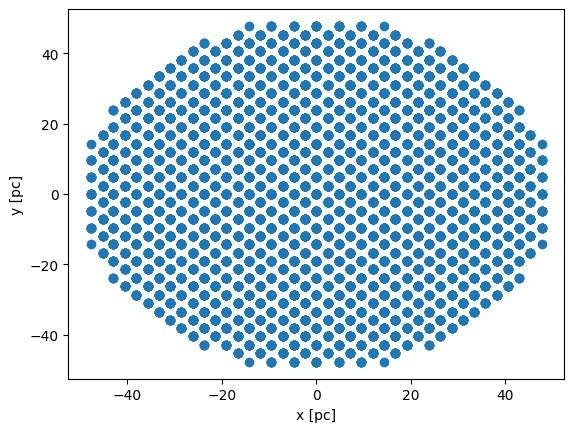

In [252]:
# plot molecular cloud particles function (discrete)
plt.scatter(particles_cloud.x.value_in(units.pc), particles_cloud.y.value_in(units.pc))
plt.xlabel("x [pc]")
plt.ylabel("y [pc]")
plt.show()

eps-h flag 0 3.08567758128e+15 m
dt_exp =  0.00936699150186 Myr
dt =  0.185131424808 Myr
eps =  0.1 parsec
Time 0.185131424808 Myr
Energy =  -2.04410944299e+45 J , Error energy =  -20.6311058011 J, Thermal energy= 1.02676191892e+44 J 

Time 0.370262849617 Myr
Energy =  -3.06372456427e+45 J , Error energy =  -30.4232294034 J, Thermal energy= 1.02676191892e+44 J 

Time 0.555394274425 Myr
Energy =  -3.41105282592e+45 J , Error energy =  -33.7588814525 J, Thermal energy= 1.02676191892e+44 J 

Time 0.740525699233 Myr
Energy =  -3.40801842645e+45 J , Error energy =  -33.7297398538 J, Thermal energy= 1.02676191892e+44 J 

Time 0.925657124041 Myr
Energy =  -3.23865472964e+45 J , Error energy =  -32.1032141008 J, Thermal energy= 1.02676191892e+44 J 

Time 1.11078854885 Myr
Energy =  -2.96323859863e+45 J , Error energy =  -29.4581878152 J, Thermal energy= 1.02676191892e+44 J 

Time 1.29591997366 Myr
Energy =  -2.64190653326e+45 J , Error energy =  -26.3721966057 J, Thermal energy= 1.02676191892e

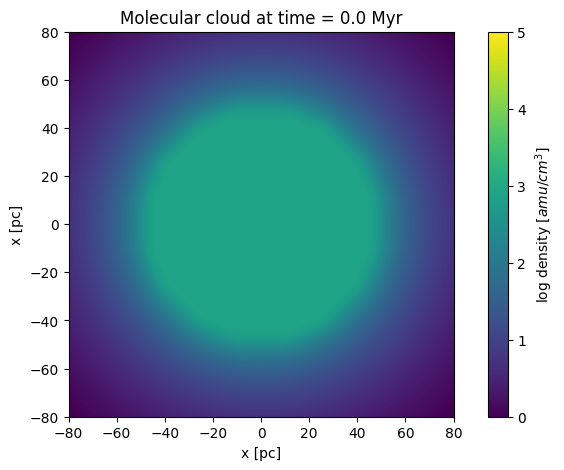

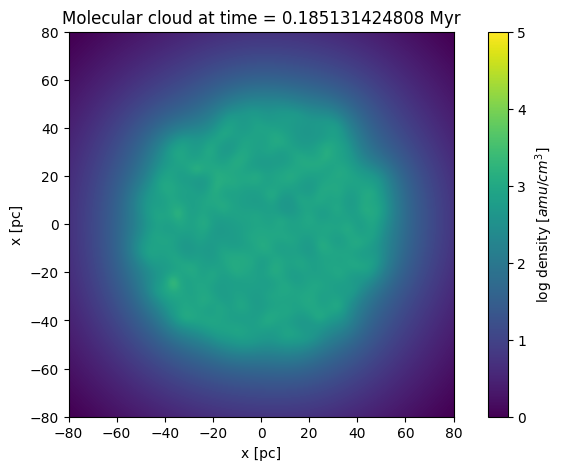

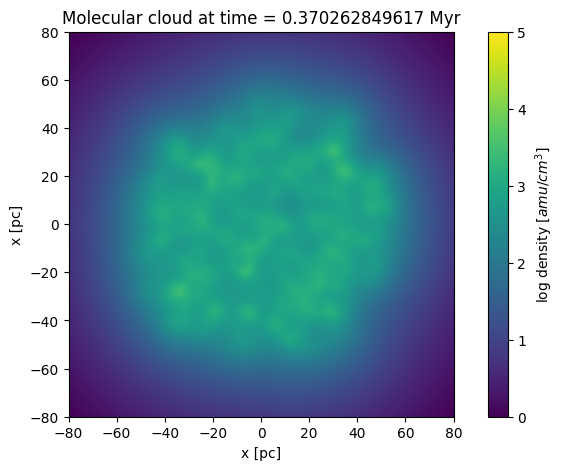

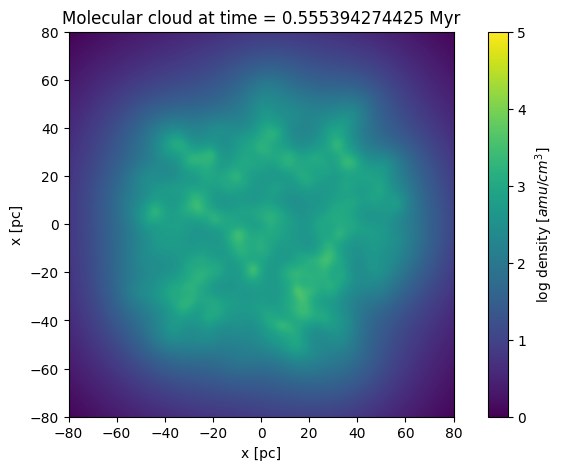

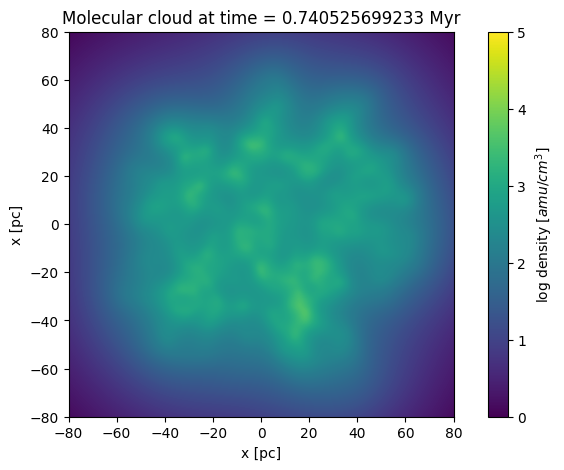

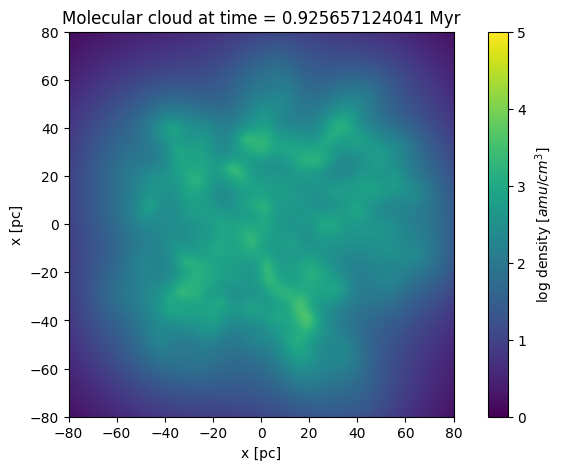

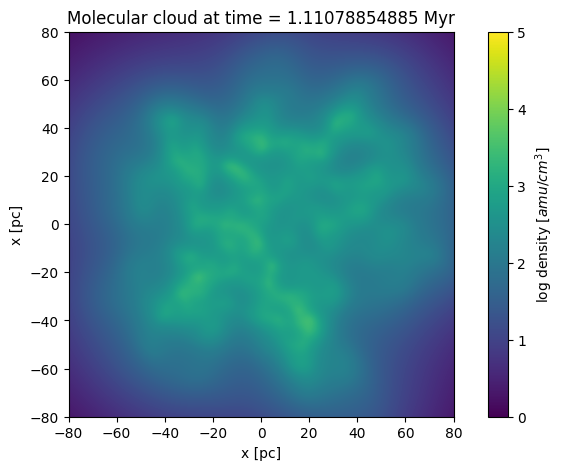

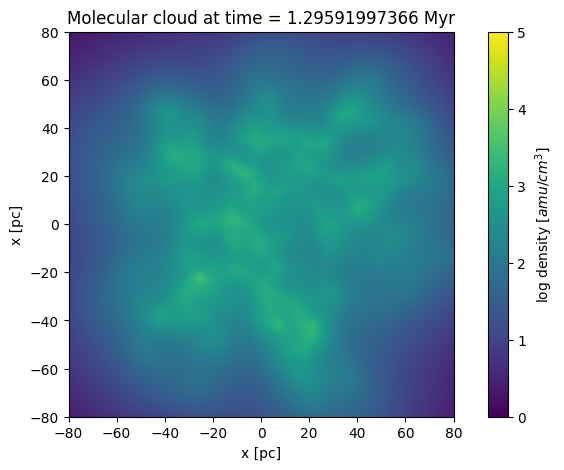

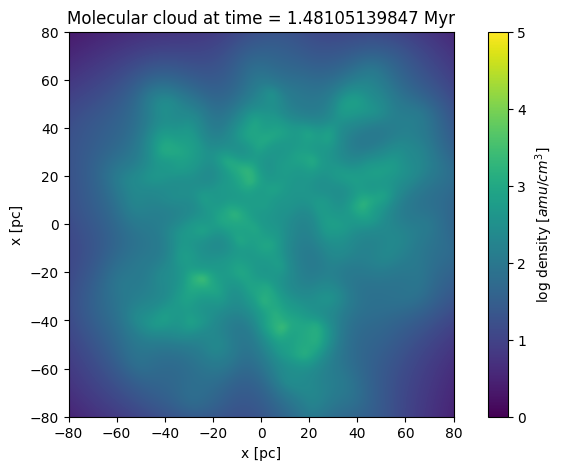

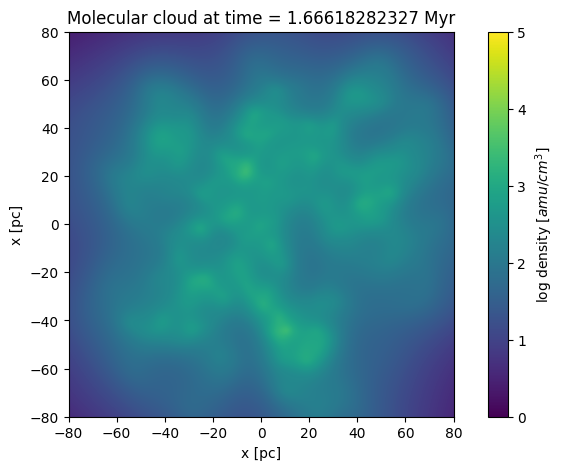

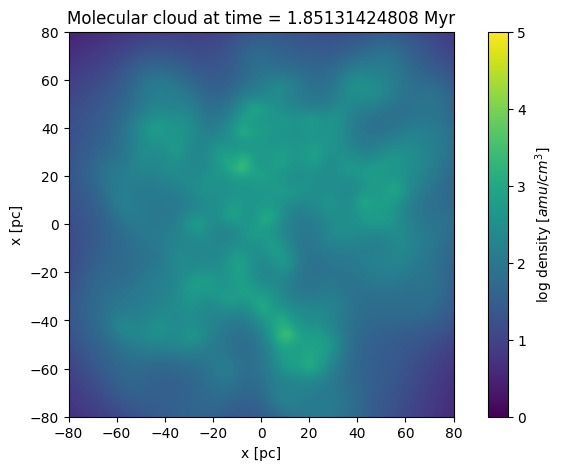

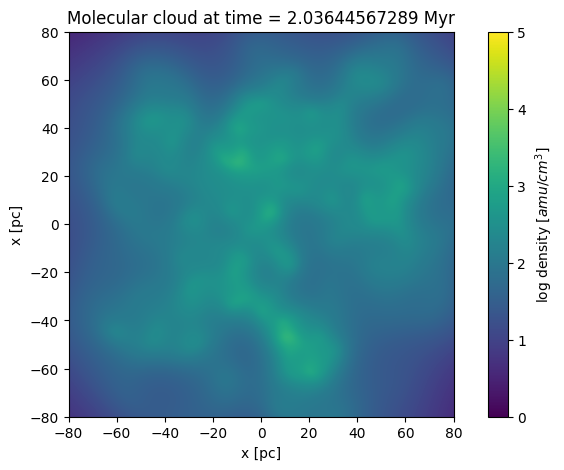

In [253]:
np.random.seed(723476)
hydro_cloud = Fi(converter_cloud) # best choice? Yes, because for TreeSPH (?)

hydro_cloud.parameters.use_hydro_flag = True # Hydrodynamics flag. True means: SPH hydro included, False means: gravity only.
hydro_cloud.parameters.radiation_flag = False # Radiation flag. True means: radiation (i.e. radiative cooling/heating) is included. False means: no radiation, and implies no star formation. (default value:False)
                                              # NOTE: we should look into this further, in tutorials this was set to "False", but molecular_cloud_to_star_cluster.py this was also set to "False"

hydro_cloud.parameters.self_gravity_flag = False # self-gravity turned off because gravity particles determined using a bridge

hydro_cloud.parameters.gamma = 1 # gas polytropic index (1.6666667) (default value:1.6666667)
hydro_cloud.parameters.isothermal_flag = True # Isothermal flag. True means: isothermal gas (requires integrate_entropy_flag == False). (default value:False)
hydro_cloud.parameters.integrate_entropy_flag = False # Integrate-entropy flag. True means: integrate entropy, else: internal energy. (default value:True)
hydro_cloud.parameters.timestep = dt*0.5 # timestep for system (default value:4.70451599238e+13 s)
hydro_cloud.parameters.verbosity = 0 # The level of terminal output (0=minimum). (default value:0)

# I don't know what the following means...
# ????????????????????????????????????????
hydro_cloud.parameters.eps_is_h_flag = False  #Eps-is-h flag. True means: set gas particles gravitational epsilon to h (SPH smoothing length). (default value:True)
                                              # h_smooth is constant
eps = 0.1 | units.parsec # QUESTION: shouldn't this depend on N_cloud?
hydro_cloud.parameters.gas_epsilon = eps # The gas gravitational smoothing epsilon.
hydro_cloud.parameters.sph_h_const = eps # SPH smoothing length if constant
particles_cloud.h_smooth= eps

print('eps-h flag', hydro_cloud.get_eps_is_h(), hydro_cloud.get_consthsm())

expected_dt = 0.2*np.pi*np.power(eps, 1.5)/np.sqrt(G*M_cloud/N_cloud)

print("dt_exp = ", expected_dt.in_(units.Myr))
print("dt = ", dt.in_(units.Myr))
print("eps = ", hydro_cloud.parameters.gas_epsilon.in_(units.parsec))
# ????????????????????????????????????????

hydro_cloud.gas_particles.add_particles(particles_cloud)

channel = {"hydro_to_part": hydro_cloud.gas_particles.new_channel_to(parts),
           "part_to_hydro": parts.new_channel_to(hydro_cloud.gas_particles)}

gravity_cloud = BHTree(converter_cloud) # QUESTION: change to PeTar?

calculate_gravity_code = bridge.CalculateFieldForCodes(
    gravity_cloud, # the code that calculates the acceleration field
    input_codes = [hydro_cloud]) # the codes to calculate the acceleration field of

bridge_gravity_hydro = bridge.Bridge(use_threading = False)
bridge_gravity_hydro.timestep = dt

bridge_gravity_hydro.add_system(
    gravity_cloud, # the code to move the particles of
    [calculate_gravity_code]) # the codes that provide the acceleration field

L = 80 # x and y lim of plot. IMPORTANT: change depending on R_cloud
N = 1000 # amount of grid points

E0 = hydro_cloud.gas_particles.kinetic_energy() \
     + hydro_cloud.gas_particles.potential_energy() \
     + hydro_cloud.gas_particles.thermal_energy()
model_time = 0.0 | units.Myr

plot_hydro(model_time, hydro_cloud, L, N)

while model_time < t_end:
    model_time += dt
    hydro_cloud.evolve_model(model_time)
    bridge_gravity_hydro.evolve_model(model_time)

    E = hydro_cloud.gas_particles.kinetic_energy() \
         + hydro_cloud.gas_particles.potential_energy() \
         + hydro_cloud.gas_particles.thermal_energy()
    E_th = hydro_cloud.gas_particles.thermal_energy()
    Eerr = (E - E0)/E0 
    print("Time", model_time.in_(units.Myr))
    print('Energy = ', E.in_(units.J), ', Error energy = ', Eerr, 'J, Thermal energy=', E_th.in_(units.J), "\n")

    channel["hydro_to_part"].copy()

    plot_hydro(model_time, hydro_cloud, L, N)

hydro_cloud.stop()
gravity_cloud.stop()